# Recurrent Neural Networks for Machine Translation

The intention of this notebook ist to show implementation, training and use of recurrent neural networks for machine translation.

In [1]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

from keras.initializers import Constant
from keras.layers import Embedding, Dense, GRU, Input, Bidirectional, RepeatVector, TimeDistributed, LSTM
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


At first, the dataset is loaded. It is split into two files, *small_vocab_en* with 137861 english sentences, and *small_vocab_fr* with the french translation of each sentence.

In [2]:
with open("./data/small_vocab_en.txt") as f:
    en_vocab = f.read()
    
with open("./data/small_vocab_fr.txt") as f:
    fr_vocab = f.read()
    
en_vocab = en_vocab.split('\n')
fr_vocab = fr_vocab.split('\n')

In [3]:
print("Number of english sentences: {}".format(len(en_vocab)))
print("Number of french sentences: {}".format(len(fr_vocab)))
print("\nExample:\n--------")
print("English:", en_vocab[0])
print("French: ", fr_vocab[0])

Number of english sentences: 137861
Number of french sentences: 137861

Example:
--------
English: new jersey is sometimes quiet during autumn , and it is snowy in april .
French:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .


The next step is to preprocess the data. The english as well as the french words are tokenized using the Keras Tokenizer. The tokenized sentences are stored to the lists `en_sequences` and `fr_sequences`. Then dictionaries that translate words to tokens and tokens back to words are genereated. A padding term is added to the token-to-word dictionaries because the token "0" is used for padding sentences to the same length but it has no corresponding word in the dataset. Also the function `token_seq_to_french_sentence()` to translate a sequence of tokens back to a french sentence is defined.

In [4]:
MAX_NUM_WORDS = 20000

# tokenize english words
en_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
en_tokenizer.fit_on_texts(en_vocab)
en_sequences = pad_sequences(en_tokenizer.texts_to_sequences(en_vocab), maxlen=None, padding='post')
max_en_len = en_sequences.shape[1]

# tokenize french words
fr_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
fr_tokenizer.fit_on_texts(fr_vocab)
fr_sequences = pad_sequences(fr_tokenizer.texts_to_sequences(fr_vocab), maxlen=None, padding='post')
max_fr_len = fr_sequences.shape[1]

# englich word => token dictionary
en_word_to_token = en_tokenizer.word_index
en_word_to_token["<PAD>"] = 0

# token => english word dictionary
en_token_to_word = {}
for word, token in en_word_to_token.items():
    en_token_to_word[token] = word

# french word => token dictionary
fr_word_to_token = fr_tokenizer.word_index
fr_word_to_token["<PAD>"] = 0

# token => french word dictionary
fr_token_to_word = {}
for word, token in fr_word_to_token.items():
    fr_token_to_word[token] = word


def token_seq_to_french_sentence(seq):
    sentence = ""
    for word in [fr_token_to_word[token] for token in seq]:
        sentence = sentence + " " + word
    return sentence

print("Sentence in dataset:\n--------------------\n", fr_vocab[0])
print("\nTokenized sentence:\n-------------------\n", fr_sequences[0])
print("\nFrom token back to sentence:\n-------------------------\n", token_seq_to_french_sentence(fr_sequences[0]))

Sentence in dataset:
--------------------
 new jersey est parfois calme pendant l' automne , et il est neigeux en avril .

Tokenized sentence:
-------------------
 [ 35  34   1   8  67  37  11  24   6   3   1 112   2  50   0   0   0   0
   0   0   0]

From token back to sentence:
-------------------------
  new jersey est parfois calme pendant l' automne et il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


The outputs of the neural translator network are the possibilities for each word in the french vocabulary. Therefore, the french sequences must be one-hot encoded so that they can be used to be compared to the word possibilities put out by the neural network.

In [5]:
fr_sequences = to_categorical(fr_sequences)

print("Shape of en_sequences: {}".format(en_sequences.shape))
print("shape of fr_sequences: {}".format(fr_sequences.shape))

Shape of en_sequences: (137861, 15)
shape of fr_sequences: (137861, 21, 346)


The neural networks, defined latet in this notebook, use GloVe word embedding. The next step is to load the word vectors from file and prepare the embedding layer. 

In [6]:
# Some parts in this cell are from or inspired by "The Keras Blog: Using
# pre-trained word embeddings in a Keras model",
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

# Load GloVe word vectors
embeddings_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coeffs

print('Loaded {} GloVe word vectors.'.format(len(embeddings_index)))

# Prepare embedding matrix
embedding_dim = embeddings_index["sunday"].shape[0]

num_words = min(MAX_NUM_WORDS, len(en_word_to_token)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in en_word_to_token.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_en_len,
                            trainable=False)

Loaded 400000 GloVe word vectors.


In [7]:
def plot_training_history(history, model_name="model"):
    """Plots the prediction accuracy and the prediction loss of a trained model
    
    Args:
        history: Training history of the model.
        model_name: Name of the trained model. Only used to give the plot a title. 
    """
    # Plot training and validation accuracy values
    plt.subplot(121)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Prediction accuracy of {}'.format(model_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Training Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    #plt.show()
    
    # Plot training and validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Prediction loss of {}'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Training Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.tight_layout()
    plt.show()

### Model 1 ###

In [8]:
class TranslatorNet1:
    """Sequence to sequence machine translation model using RepeatVector
    
    This model uses an encoder with a bidirectional GRU layer. After the
    complete input sequence is fed into the encoder, the GRU layer returns
    a vector. This vector is repeated to a matrix with as many rows as the
    output sequence length. The this matrix is fed into
    the decoder. The decoder is a GRU layer followed by a Dense layer.
    For each vector that is fed into the decoder, it produces an output
    vector that is fed into the dense layer and produces one element of
    the output sequence.
    
    Attributes:
        model: The implementation of the neural network.
    """
    
    self.model = None
    
    
    def __init__(self, input_sequence_length, output_sequence_length,
                 output_dimension, embedding_layer=None, input_dimension=None):
        """Inits the neural network
        
        Args:
            input_sequence_length: Number of elements in the input sequence
                (all input sequences must be of a fix length).
            output_sequence_length: Number of elements in the output sequence
                (all output sequences must be of a fix length).
            output_dimension: Number of possible output categories, here it is
                the number of different words in the french vocabulary.
            embedding_layer: A given keras.layers.Embedding object that is used
                for the word embedding. If this is None, the model uses an untrained
                embedding layer and trains it during training phase.
            input_dimension: Number of input categories (different words in the
                english vocabulary). Can be None if an embedding layer is provided.
        """
        # encoder
        model_input = Input(shape=(input_sequence_length,), dtype='int32')
        if embedding_layer is None:
            if input_dimension is None:
                raise ValueError("If embedding_layer is None, input_dimension must be specified.")
            emb = Embedding(input_dimension, 64, input_length=input_sequence_length,
                            mask_zero=False)(model_input)
        else:
            emb = embedding_layer(model_input)
        enc_gru = Bidirectional(GRU(units=256, return_sequences=False))(emb)
        rep = RepeatVector(output_sequence_length)(enc_gru)
        # decoder
        dec_gru = GRU(units=256, return_sequences=True)(rep)
        out = TimeDistributed(Dense(output_dimension, activation="softmax"))(dec_gru)
        self.model = Model(model_input, out)
        self.model.compile(loss="categorical_crossentropy",
                           optimizer="adam", metrics=['accuracy'])
        
    def fit_on_data(self, input_sequences, output_sequences, epochs=10, validation_split=0.2):
        """Trains and evaluates the model on a given dataset
        
        Args:
            input_sequences: Input to the model for training and evaluation.
            output_sequences: Correct output corresponding to the input.
            epochs: Number of training epochs.
            validation_split: Determines the size of the given dataset that is used
                for training and that is used for evaluation.
                
        Returns:
            history: The training history.
        """
        history = self.model.fit(input_sequences, output_sequences,
                                 validation_split=validation_split,
                                 batch_size=1024, epochs=epochs,
                                 verbose=1)
        return history

    def predict(self, input_sequence):
        """Use the trained model for prediction.
        
        Args:
            input_sequence: Sequence of english word tokens to be translated to
                french by the previously trained model.
                
        Returns:
            output_sequence: Token sequence of french words.
        """
        output = self.model.predict(input_sequence.reshape(1,-1))
        token_seq = [np.argmax(row) for row in output[0]]
        output_sequence = np.array(token_seq)
        return output_sequence

In [9]:
translator_1 = TranslatorNet1(input_sequence_length=max_en_len, output_sequence_length=max_fr_len,
                            output_dimension=len(fr_token_to_word), input_dimension=len(en_token_to_word))

translator_1.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 15, 64)            12800     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               493056    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 21, 512)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 21, 256)           590592    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 21, 346)           88922     
Total params: 1,185,370
Trainable params: 1,185,370
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = translator_1.fit_on_data(en_sequences, fr_sequences, epochs=20)

Train on 110288 samples, validate on 27573 samples
Epoch 1/20
110288/110288 [==============================] - 40s 365us/step - loss: 3.0559 - acc: 0.4385 - val_loss: 2.4381 - val_acc: 0.4725
Epoch 2/20
110288/110288 [==============================] - 37s 338us/step - loss: 2.1342 - acc: 0.5057 - val_loss: 1.8671 - val_acc: 0.5377
Epoch 3/20
110288/110288 [==============================] - 37s 338us/step - loss: 1.7170 - acc: 0.5634 - val_loss: 1.5508 - val_acc: 0.5934
Epoch 4/20
110288/110288 [==============================] - 37s 338us/step - loss: 1.4658 - acc: 0.6100 - val_loss: 1.3781 - val_acc: 0.6276
Epoch 5/20
110288/110288 [==============================] - 38s 347us/step - loss: 1.3174 - acc: 0.6377 - val_loss: 1.2475 - val_acc: 0.6519
Epoch 6/20
110288/110288 [==============================] - 40s 360us/step - loss: 1.1762 - acc: 0.6699 - val_loss: 1.1007 - val_acc: 0.6863
Epoch 7/20
110288/110288 [==============================] - 41s 372us/step - loss: 1.0450 - acc: 0.6992

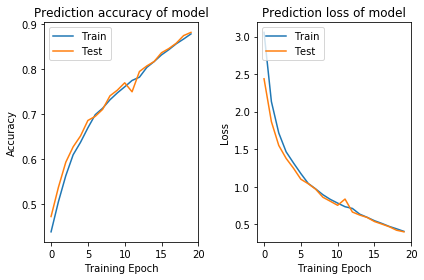

In [11]:
plot_training_history(history)

### Model 2 ###

In [12]:
class TranslatorNet2:
    """Sequence to sequence machine translation model using encoder-decoder scheme
    
    This model uses an encoder consisting of an embedding layer and an LSTM layer.
    The LSTM layer takes the whole input sequence and returns its latest states
    to the decoder. The decoder also uses an LSTM layer and a dense layer. The LSTM
    layer of the decoder is initialized with the states of the encoder. Then the
    decoder produces the output sequence token by token.
    
    Attributes:
        training_model: Model for the training process.
        inference_encoder: Encoder model for inference. Its layers are part of the
            training model and are trained during the training process.
        inference_decoder: Decoder model for inference. Its layers are part of the
            training model and are trained during the training process.
    """
    
    self.training_model = None
    self.inference_encoder = None
    self.inference_decoder = None
    
    def __init__(self, input_sequence_length, output_sequence_length,
                 output_dimension, embedding_layer=None, input_dimension=None):
        """Inits the neural network
        
        Args:
            input_sequence_length: Number of elements in the input sequence
                (all input sequences must be of a fix length).
            output_sequence_length: Number of elements in the output sequence
                (all output sequences must be of a fix length).
            output_dimension: Number of possible output categories, here it is
                the number of different words in the french vocabulary.
            embedding_layer: A given keras.layers.Embedding object that is used
                for the word embedding. If this is None, the model uses an untrained
                embedding layer and trains it during training phase.
            input_dimension: Number of input categories (different words in the
                english vocabulary). Can be None if an embedding layer is provided.
        """
        self.output_dimension = output_dimension
        self.output_sequence_length = output_sequence_length
        # encoder
        enc_input = Input(shape=(input_sequence_length,), dtype='int32')
        if embedding_layer is None:
            if input_dimension is None:
                raise ValueError("If embedding_layer is None, input_dimension must be specified.")
            emb = Embedding(input_dimension, 64, input_length=input_sequence_length,
                            mask_zero=False)(enc_input)
        else:
            emb = embed_layer(enc_input)
        
        enc_lstm = LSTM(128, return_state=True, return_sequences=False)
        enc_out, state_h, state_c = enc_lstm(emb)
        enc_state = [state_h, state_c]
        
        # decoder
        dec_input = Input(shape=(None, output_dimension))
        dec_lstm = LSTM(128, return_sequences=True, return_state=True)
        dec_lstm_out, _, _ = dec_lstm(dec_input, initial_state=enc_state)
        dec_dense = Dense(output_dimension, activation="softmax")
        dec_out = dec_dense(dec_lstm_out)
        
        # training model
        self.training_model = Model([enc_input, dec_input], dec_out)

        # inference encoder
        self.inference_encoder = Model(enc_input, enc_state)
        
        # inference decoder
        input_state_h = Input(shape=(128,))
        input_state_c = Input(shape=(128,))
        input_state = [input_state_h, input_state_c]
        dec_lstm_out, state_h, state_c = dec_lstm(dec_input, initial_state=input_state)
        dec_state = [state_h, state_c]
        dec_out = dec_dense(dec_lstm_out)
        
        self.inference_decoder = Model([dec_input] + input_state, [dec_out] + dec_state)
        
        learning_rate = 0.01
        self.training_model.compile(loss="categorical_crossentropy",
                                    optimizer=Adam(learning_rate), metrics=['accuracy'])
    
    def fit_on_data(self, input_sequences, output_sequences, epochs=10, validation_split=0.2):
        """Trains and evaluates the model on a given dataset
        
        Args:
            input_sequences: Input to the model for training and evaluation.
            output_sequences: Correct output corresponding to the input.
            epochs: Number of training epochs.
            validation_split: Determines the size of the given dataset that is used
                for training and that is used for evaluation.
                
        Returns:
            history: The training history.
        """
        pad_hot_encoded = np.array([1] + (fr_sequences[0].shape[1] - 1)*[0])
        shifted_output_sequences = np.copy(output_sequences)
        for seq in shifted_output_sequences:
            seq[...] = np.vstack((pad_hot_encoded, seq[:-1]))
        
        history = self.training_model.fit([input_sequences, shifted_output_sequences], output_sequences,
                                          validation_split=validation_split, batch_size=1024,
                                          epochs=epochs, verbose=1)
        return history
    
    def predict(self, input_sequence):
        """Use the trained model for prediction.
        
        Args:
            input_sequence: Sequence of english word tokens to be translated to
                french by the previously trained model.
                
        Returns:
            output_sequence: Token sequence of french words.
        """
        # encode
        state = self.inference_encoder.predict(input_sequence.reshape(1,-1))
        # start of sequence input
        target_seq = np.array([0.0 for _ in range(self.output_dimension)]).reshape(1, 1, self.output_dimension)
        # collect predictions
        output = list()
        for t in range(self.output_sequence_length):
            # predict next word
            yhat, h, c = self.inference_decoder.predict([target_seq] + state)
        
            output.append(yhat[0, 0, :])
        
            state = [h, c]
        
            target_seq = yhat
        token_seq = [np.argmax(row) for row in output]
        output_sequence = np.array(token_seq)
        return output_sequence

In [13]:
translator_2 = TranslatorNet2(input_sequence_length=max_en_len, output_sequence_length=max_fr_len,
                            output_dimension=len(fr_token_to_word), input_dimension=len(en_token_to_word))

translator_2.training_model.summary()
translator_2.inference_encoder.summary()
translator_2.inference_decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 15, 64)       12800       input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None, 346)    0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 128), (None, 98816       embedding_3[0][0]                
__________________________________________________________________________________________________
lstm_2 (LS

In [14]:
history = translator_2.fit_on_data(en_sequences, fr_sequences, epochs=20)

Train on 110288 samples, validate on 27573 samples
Epoch 1/20
110288/110288 [==============================] - 29s 266us/step - loss: 1.7437 - acc: 0.6052 - val_loss: 0.7588 - val_acc: 0.7467
Epoch 2/20
110288/110288 [==============================] - 25s 228us/step - loss: 0.6407 - acc: 0.7760 - val_loss: 0.5487 - val_acc: 0.7992
Epoch 3/20
110288/110288 [==============================] - 25s 226us/step - loss: 0.4782 - acc: 0.8293 - val_loss: 0.3804 - val_acc: 0.8666
Epoch 4/20
110288/110288 [==============================] - 26s 238us/step - loss: 0.3062 - acc: 0.8939 - val_loss: 0.2230 - val_acc: 0.9257
Epoch 5/20
110288/110288 [==============================] - 25s 223us/step - loss: 0.1581 - acc: 0.9519 - val_loss: 0.1052 - val_acc: 0.9721
Epoch 6/20
110288/110288 [==============================] - 25s 229us/step - loss: 0.0801 - acc: 0.9789 - val_loss: 0.0641 - val_acc: 0.9837
Epoch 7/20
110288/110288 [==============================] - 25s 229us/step - loss: 0.0511 - acc: 0.9870

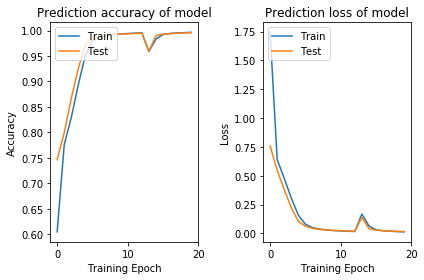

In [15]:
plot_training_history(history)

In [16]:
def translate(english_sentence, model):
    """ Translate an english sentence into french using a given model
    
    Args:
        english_sentence: English sentence as a string, e.g. "The sun always shines on TV!".
        model: Keras model that should be used for trainslation.
    """
    english_token_sequence = en_tokenizer.texts_to_sequences([english_sentence])[0]
    padding_len = max_en_len - len(english_token_sequence)
    english_token_sequence = english_token_sequence + padding_len*[0]
    french_token_sequence = model.predict(np.array(english_token_sequence))
    french_sentence = token_seq_to_french_sentence(french_token_sequence)
    return french_sentence
    
print(translate(en_vocab[291], translator_1))
print(translate(en_vocab[291], translator_2))
print(fr_vocab[291])

 l' inde est jamais agrã©able au printemps mais il gã¨le en en fã©vrier <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
 l' inde est jamais belle au printemps mais il gã¨le habituellement en fã©vrier <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
l' inde est jamais belle au printemps , mais il gÃ¨le habituellement en fÃ©vrier .
